## To-do:

- Post-processing step snapping nearby nodes together. In case of clusters, do that iteratively.
- Ensure we preserve attributes and mark our changes

In [1]:
import logging

import matplotlib.pyplot as plt
import momepy
from libpysal import graph

from core import algorithms, utils


Set logging level to debug to see the debugging messages.

In [2]:
logging.basicConfig(level=logging.DEBUG)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_original(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Identify artifacts

In [6]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [7]:
_, r_idx = roads.sindex.query(artifacts.geometry, predicate="contains")
roads = roads.drop(roads.index[r_idx])

Filter only singleton artifacts

In [8]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)

# keep only those artifacts which occur as isolates, i.e. are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)]

Optionally define a subset of data.

In [9]:
data_sample = artifacts.loc[[3509, 173]]

Simplify singleton artifacts.

In [10]:
new_roads = algorithms.simplify.simplify_singletons(data_sample, roads)

DEBUG:root:FUNCTION nx_gx
DEBUG:root:CONDITION n_comps > 1 True
DEBUG:root:CONDITION relevant_targets.shape[0] > 0 True
DEBUG:root:CONDITION remaining_nodes.shape[0] < 2 True
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
DEBUG:root:CONDITION is_within False
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
DEBUG:root:FUNCTION nx_gx
DEBUG:root:CONDITION n_comps > 1 True
DEBUG:root:CONDITION relevant_targets.shape[0] > 0 True
DEBUG:root:CONDITION remaining_nodes.shape[0] < 2 True
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs

Visual exploration of the result.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/martin/miniforge3/envs/simplif

3509


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/GujaratiMT.ttc', name='Gujarati MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSerifMyanmar.ttc', name='Noto Serif Myanmar', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCham-Regular.ttf', name='Noto Sans Cham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Cochin.ttc', name='Cochin', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/AppleSDGo

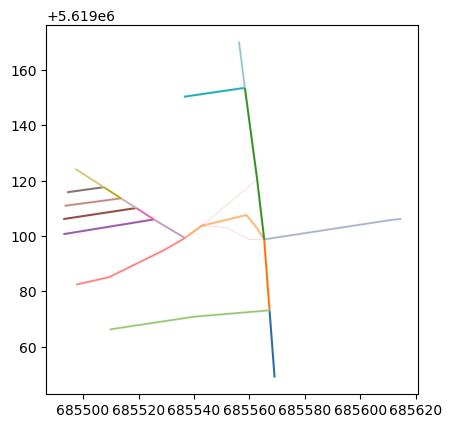

173


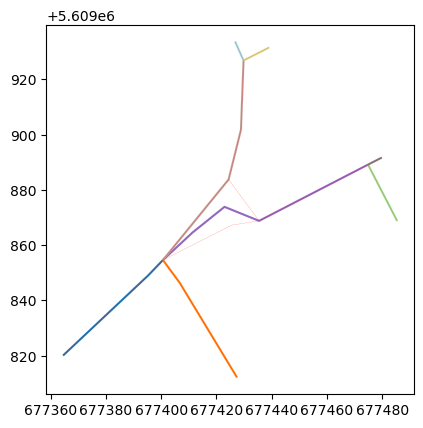

In [11]:
for artifact in data_sample.itertuples():
    print(artifact.Index)

    # plot the results for visual verification
    geom = artifact.geometry
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()